<a href="https://colab.research.google.com/github/ttury/Deep-Learning-For-Natural-Language-Processing/blob/master/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

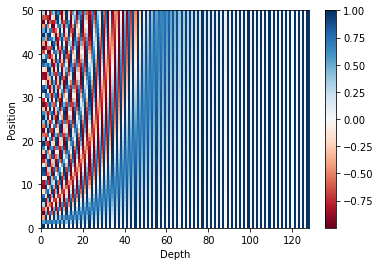

In [69]:
# Positional Encoding

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    # i = 2n인 경우와 i = 2n + 1인 경우 모두 2n으로 맞춰주기 위해 사용, cast는 형변환 함수
    return position * angles
    # (pos, d_model) 크기의 2D 텐서

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        # 0 ~ pos 까지 1씩 커지는 (pos, 1) 크기의 2D 텐서
        i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        # 0 ~ d_model 까지 1씩 커지는 (1, d_model) 크기의 2D 텐서
        d_model = d_model
    )

    sines = tf.math.sin(angle_rads[:, 0::2])
    # 행별로 짝수 인덱스에 sin 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])
    # 행별로 홀수 인덱스에 cos 적용

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    pos_encoding = tf.constant(angle_rads)[tf.newaxis, ...] # 3D 텐서 생성

    # print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)
  
  def call(self, inputs):
    return inputs + self.pos_encoding

sample_pos_encoding = PositionalEncoding(50, 128)
# 문장의 길이 : 50, 임베딩 벡터의 차원 : 128

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
# .numpy() : tf.tensor -> np.ndarray, x축이 빈 축이므로 [0] 사용해서 y, z축 사용
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [4]:
# Scaled dot-product Attention

def scaled_dot_product_attention(query, key, value, mask):
  attention_score = tf.matmul(query, key, transpose_b = True)
  # query : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (1, key의 문장 길이)
  # num_heads의 경우 이후 멀티 헤드 어텐션 함수에서 설명

  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  # n_model 에서 축소된 차원 (n_model / num_heads)
  attention_score = attention_score / tf.math.sqrt(depth)
  # 행 벡터의 길이에 루트를 씌워 나눔

  # padding mask : 의미없는 패딩 토큰 무시, attention_score에서 패드 토큰이 있는 열(key 차원)을 매우 작은 음수로 마스킹
  # 마스킹한 열은 소프트맥스 함수를 지나며 값이 0이 되어 이후 연산에 참여하지 않음
  if mask is not None:
    attention_score += (mask * -1e9)
  
  attention_weights = tf.nn.softmax(attention_score, axis=-1)
  # key의 문장 길이 차원을 기준으로 소프트맥스 활성화
  output = tf.matmul(attention_weights, value)
  # 가중치합, (문장 길이, n_model / num_heads) 크기의 2D 텐서

  return output, attention_weights

In [5]:
np.set_printoptions(suppress=True)

# 인코더(k, v) - 디코터(q) 어텐션에서는 query, key, value의 길이는 다를 수 있다.
temp_k = tf.constant([[10, 0, 0],
                        [0, 10, 0],
                        [0, 0, 10],
                        [0, 0, 10]], dtype=tf.float32)
temp_v = tf.constant([[1, 0],
                        [10, 0],
                        [100, 5],
                        [1000, 6]], dtype=tf.float32)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)

temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)

# query가 key의 두번째 값과 일치하므로 어텐션 분포의 두번째 인덱스만 1의 값을 가짐
# 결과적으로 value의 두번째 값이 출력됨

tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [6]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)

# query가 key의 3, 4번째 값과 일치하므로 어텐션 분포의 3, 4번째 인덱스가 각각 0.5, 0.5가 됨
# 결과적으로 value의 3, 4번째 값에 각각 0.5를 곱해 더한 값이 출력됨

tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [7]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)
temp_out, temp_attn = scaled_dot_product_attention(temp_q, temp_k, temp_v, None)
print(temp_attn)
print(temp_out)

tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [67]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert self.d_model % self.num_heads == 0

    self.depth = self.d_model // self.num_heads

    # Q, K, V를 만드는 데 사용하는 가중치 행렬(WQ, WK, WV)
    # 뒤에서 나눌 것이기 때문에 전체 길이(d_model)을 사용
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # Q, K, V를 합친 뒤 context vector를 만들 때 사용하는 가중치 행렬(WO)
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 Q, K, V를 나눔
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)
    )
    return tf.transpose(inputs, perm=[0, 2, 1, 3])
    # 반환값인 4D 텐서에는 num_heads 개수의 Q, K, V가 존재
  
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # WQ, WK, WV 밀집층 지나기
    # q : (batch_size, num_heads, query의 문장 길이, d_model)
    # k : (batch_size, num_heads, key의 문장 길이, d_model)
    # v : (batch_size, num_heads, value의 문장 길이, d_model)
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, depth)
    # k : (batch_size, num_heads, key의 문장 길이, depth)
    # v : (batch_size, num_heads, value의 문장 길이, depth)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 셀프 어텐션 수행
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 헤드 연결(concatenate)하기
    # 합쳐졌으므로 나눠졌을 때 사용한 num_heads 차원이 사라짐
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

    # WO 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [59]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  # dff는 피드 포워드 신경망에서 은닉층의 크기

  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 셀프 어텐션 (첫번째 서브층)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query' : inputs, 'key' : inputs, 'value' : inputs, # 셀프 어텐션이므로 Q, K, V 구분 x
          'mask' : padding_mask
      }) # keras에서 커스텀 레이어를 만들 때 call 함수가 필수적인데, call 함수의 input값을 주기 위해 괄호 두개 사용

  # 드랍아웃 : 과적합을 막기 위해 랜덤으로 은닉층 몇개를 비활성화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  # 잔차 연결(입력 + 출력) + 레이어 정규화(평균 더한 뒤 표준편차로 나누기)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 피드 포워드 신경망 (두번째 서브층)
  # 은닉층
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  # 출력층
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드랍아웃 + 잔차 연결 + 레이어 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [61]:
# 인코더 층을 num_layer 개수로 쌓기

def encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="encoder"):

  inputs = tf.keras.Input(shape=(None,), name="inputs")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(dff, d_model, num_heads, dropout, "encoder_layer_{}".format(i))([outputs, padding_mask])
    # encoder_layer 함수의 return문에서의 input값을 두 번째 괄호로 입력
  
  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [53]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # 정수 시퀀스에서 0인 경우는 1로 변환, 그렇지 않으면 0으로 변환
  # 1로 변환된 위치는 이후 매우 작은 음수로 마스킹됨
  return mask[:, tf.newaxis, tf.newaxis, :]
  # (batch_size, 1, 1, key의 문장 길이)

print(create_padding_mask(tf.constant([[1, 21, 777, 0, 0]])))

tf.Tensor([[[[0. 0. 0. 1. 1.]]]], shape=(1, 1, 1, 5), dtype=float32)


In [54]:
# look-ahead mask

def create_look_ahead_mask(x):
  # x는 정수 인코딩된 텐서 (batch_size, 문장 길이)
  seq_len = tf.shape(x)[1] # 문장 길이
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # 역직각삼각형
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))
# 삼각형 마스킹, 패딩 마스크가 포함되어 3번째 열도 마스킹

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [63]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 서브층 1, Masked Multi-head Self-Attention(look-ahead mask)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query' : inputs, 'key' : inputs, 'value' : inputs,
          'mask' : look_ahead_mask
      })

  # 잔차 연결 + 레이어 정규화
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention1)

  # 서브층 2, Encoder-Decoder Attention(padding mask)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query' : attention1, 'key' : enc_outputs, 'value' : enc_outputs,
          'mask' : padding_mask
      })
  
  # 드랍아웃 + 잔차 연결 + 레이어 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + attention2)

  # 서브층 3, 피드 포워드 신경망
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드랍아웃 + 잔차 연결 + 레이어 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + outputs)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [65]:
def decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="decoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드랍아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layer 개수 만큼 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff, d_model, num_heads, dropout, "decoder_layer_{}".format(i))(
        inputs = [outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs = [inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs = outputs,
      name = name)

In [57]:
def transformer(vocab_size, num_layers, dff, d_model, num_heads, dropout, name="transformer"):

  # 인코더와 디코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name="enc_padding_mask")(inputs)

  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name="look_ahead_mask")(dec_inputs)
  
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name="dec_padding_mask")(inputs)
  
  enc_outputs = encoder(vocab_size, num_layers, dff, d_model, num_heads, dropout)(
      inputs = [inputs, enc_padding_mask])
  
  dec_outputs = decoder(vocab_size, num_layers, dff, d_model, num_heads, dropout)(
      inputs = [dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
  
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

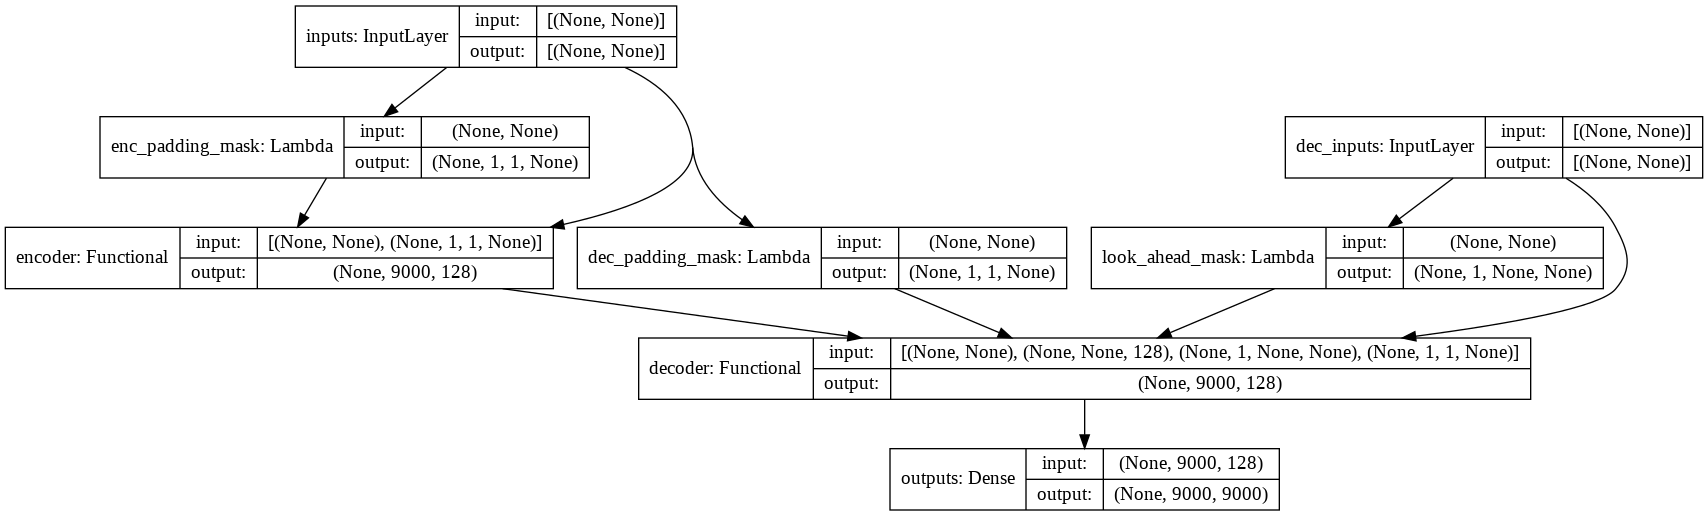

In [70]:
small_transformer = transformer(
    vocab_size = 9000,
    num_layers = 4,
    dff = 512,
    d_model = 128,
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file="small_transformer.png", show_shapes=True)

In [71]:
def loss_function(y, y_hat):
  y = tf.reshape(y, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y, y_hat)
  
  mask = tf.cast(tf.not_equal(y, 0), tf.float32) # 패딩 마스크
  loss = tf.multiply(loss, mask) # 원소곱

  return tf.reduce_mean(loss) # 행렬의 모든 원소의 평균

In [82]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps
  
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step) # step^-0.5
    arg2 = step * (self.warmup_steps**-1.5)
    l_rate = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    return l_rate

Text(0.5, 0, 'Train Step')

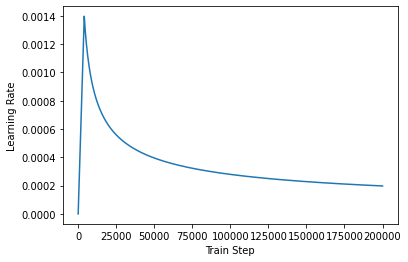

In [83]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")